In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337

set_seed(seed)

In [3]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [4]:
from dotenv import load_dotenv

load_dotenv()

from service import EnvironmentSecretService

In [5]:
from core.models.exchange import ExchangeType
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe
from exchange import ExchangeFactory

In [6]:
DEFAULT_EXCHANGE = ExchangeType.BYBIT
DEFAULT_TIMEFRAME = Timeframe.FIFTEEN_MINUTES
DEFAULT_LOOKBACK = Lookback.EIGHT_MONTH

from datetime import datetime

today = datetime.now().strftime('%Y-%m-%d')

raw_df_filename = f'ocean_raw_{DEFAULT_TIMEFRAME}_{DEFAULT_LOOKBACK}_{today}.csv'
features_filename = f'ocean_features_{today}.npy'
emb_filename = f'ocean_emb_{today}.npy'
volume_df_filename = f'ocean_vol_{today}.csv'

In [ ]:
exchange_factory = ExchangeFactory(EnvironmentSecretService())
exchange = exchange_factory.create(DEFAULT_EXCHANGE)

In [ ]:
symbols = exchange.fetch_future_symbols()

data = []
for symbol in symbols:
    try:
        for ohlcv in exchange.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
            _timestamp, _open, _high, _low, _close, _volume = ohlcv
            data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')

symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [ ]:
symbols_df.to_csv(raw_df_filename, index=False)

In [ ]:
symbols_df = pd.read_csv(raw_df_filename)
float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')

symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'])
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [ ]:
symbols_df.head()

In [ ]:
def volume_features(df, period_14=14, period_20=20):
    df = df.copy()

    df['Date'] = df['Timestamp'].dt.date

    df['Previous Close'] = df.groupby('Symbol')['Close'].shift(1)

    df['ADV'] = df.groupby(['Symbol', 'Date'])['Volume'].transform('mean')

    df['Typical Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Cumulative Price * Volume'] = df['Typical Price'] * df['Volume']

    df['Cum_Volume'] = df.groupby(['Symbol', 'Date'])['Volume'].cumsum()
    df['Cum_Price_Volume'] = df.groupby(['Symbol', 'Date'])['Cumulative Price * Volume'].cumsum()

    df['VWAP'] = df['Cum_Price_Volume'] / df['Cum_Volume'].replace(0, 1e6)
    df['VWAP_MOM'] = df.groupby('Symbol')['VWAP'].diff()

    df['Midpoint Move'] = (df['High'] + df['Low']) / 2 - (df['High'].shift(1) + df['Low'].shift(1)) / 2
    df['Box Ratio'] = (df['Volume'] / 1e6) / (df['High'] - df['Low']).replace(0, 1e6)
    df['EOM'] = df['Midpoint Move'] / df['Box Ratio']
    df['EOM'] = df.groupby('Symbol')['EOM'].transform(lambda x: x.rolling(window=period_14).mean())

    df['Price Change'] = df.groupby(['Symbol', 'Date'])['Close'].diff()

    df['OBV_Sign'] = df['Price Change'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    df['OBV'] = (df['OBV_Sign'] * df['Volume']).groupby(df['Symbol']).cumsum()

    df['A/D'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / ((df['High'] - df['Low']) * df['Volume']).replace(0, 1e6)
    df['A/D'] = df.groupby(['Symbol', 'Date'])['A/D'].cumsum()

    df['CMF'] = df['A/D'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).sum())

    df['Amihud_Illiquidity'] = df['Price Change'].abs() / df['Volume']
    df['Amihud_Illiquidity'] = df.groupby(['Symbol', 'Date'])['Amihud_Illiquidity'].transform('mean')

    df['Liquidity_Ratio'] = df['Volume'] / df['Typical Price'].replace(0, 1e6)

    df['II'] = (2 * df['Close'] - df['High'] - df['Low']) / ((df['High'] - df['Low']) * df['Volume']).replace(0, 1e6)

    df['Raw Money Flow'] = df['Typical Price'] * df['Volume']
    df['Price Diff'] = df.groupby(['Symbol', 'Date'])['Typical Price'].diff()
    df['Positive Money Flow'] = df['Raw Money Flow'].where(df['Price Diff'] > 0, 0)
    df['Negative Money Flow'] = df['Raw Money Flow'].where(df['Price Diff'] < 0, 0)
    df['Positive Money Flow Sum'] = df.groupby('Symbol')['Positive Money Flow'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Negative Money Flow Sum'] = df.groupby('Symbol')['Negative Money Flow'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Money Flow Ratio'] = df['Positive Money Flow Sum'] / df['Negative Money Flow Sum'].replace(0, 1e6)
    df['MFI'] = 100 - (100 / (1 + df['Money Flow Ratio']))

    df['TR1'] = df['High'] - df['Low']
    df['TR2'] = (df['High'] - df['Previous Close']).abs()
    df['TR3'] = (df['Low'] - df['Previous Close']).abs()
    df['True Range'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)

    df['LII'] = df['Volume'] / (df['Typical Price'] * df['True Range']).replace(0, 1e6)

    df['HL'] = df['High'] - df['Low']

    df['Buy Volume'] = df['Volume'].where(df['Price Change'] > 0, 0)
    df['Sell Volume'] = df['Volume'].where(df['Price Change'] < 0, 0)
    df['Volume Delta'] = df['Buy Volume'] - df['Sell Volume']

    df['Volume_IMB'] = df.groupby('Symbol')['Volume Delta'].transform(lambda x: x.rolling(window=period_20).sum())
    df['Flow_R'] = df['Buy Volume'] / df['Sell Volume'].replace(0, 1e6)

    df['CVD'] = df['Buy Volume'] - df['Sell Volume']
    df['CVD'] = df.groupby('Symbol')['CVD'].cumsum()

    df['RVOL'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).mean()).replace(0, 1e6)

    df['KVO'] = (df['Volume'] * (2 * (df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])).ewm(span=period_14, adjust=False).mean().replace(0, 1e6)

    df['VROC'] = df['Volume'].pct_change(period_14)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    df.drop(columns=[
        'Date', 'Typical Price', 'Cum_Volume', 'Cum_Price_Volume', 'Cumulative Price * Volume', 'Buy Volume', 'Sell Volume', 'Midpoint Move',
        'Price Change', 'OBV_Sign', 'Raw Money Flow', 'Price Diff', 'True Range', 'Money Flow Ratio', 'Volume Delta', 'Box Ratio',
        'Positive Money Flow', 'Negative Money Flow', 'Positive Money Flow Sum', 'Negative Money Flow Sum', 'Previous Close',  'TR1', 'TR2', 'TR3'
    ], inplace=True)

    return df

In [ ]:
volume_df = volume_features(symbols_df)
volume_df.to_csv(volume_df_filename, index=False)

In [7]:
volume_df = pd.read_csv(volume_df_filename)

In [8]:
volume_df.shape[0]

8034150

In [9]:
volume_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume,ADV,VWAP,VWAP_MOM,...,II,MFI,LII,HL,Volume_IMB,Flow_R,CVD,RVOL,KVO,VROC
0,10000000AIDOGEUSDT,2024-03-05 10:45:00,0.004816,0.004816,0.004807,0.004807,400.0,213498380.0,0.004810,NaN,...,-2.500000e-03,NaN,9.240178e+09,0.000009,NaN,0.0000,0.0,NaN,-4.000000e+02,NaN
1,10000000AIDOGEUSDT,2024-03-05 11:00:00,0.004807,0.006305,0.004617,0.006210,719649400.0,213498380.0,0.005711,0.000901,...,1.233157e-09,NaN,7.465549e+13,0.001688,NaN,719.6494,719649400.0,NaN,1.757055e+08,NaN
2,10000000AIDOGEUSDT,2024-03-05 11:15:00,0.006210,0.007224,0.005910,0.006182,743186300.0,213498380.0,0.006081,0.000370,...,-7.884923e-10,NaN,8.784284e+13,0.001314,NaN,0.0000,-23536896.0,NaN,1.147229e+08,NaN
3,10000000AIDOGEUSDT,2024-03-05 11:30:00,0.006182,0.006208,0.005710,0.005939,321725900.0,213498380.0,0.006057,-0.000023,...,-2.496596e-10,NaN,1.085350e+14,0.000498,NaN,0.0000,-345262800.0,NaN,1.157066e+08,NaN
4,10000000AIDOGEUSDT,2024-03-05 11:45:00,0.005939,0.006073,0.005634,0.005765,209583600.0,213498380.0,0.006033,-0.000025,...,-1.923765e-09,NaN,8.197313e+13,0.000439,NaN,0.0000,-554846400.0,NaN,9.735090e+07,NaN


In [10]:
symbols = volume_df['Symbol'].unique()
n_symbols = len(symbols)

print("N Symbols: ", n_symbols)

N Symbols:  411


In [11]:
volume = ['ADV', 'RVOL', 'Volume_IMB', 'CVD', 'VROC']
price_volume = ['VWAP', 'VWAP_MOM', 'MFI', 'Flow_R', 'KVO', 'EOM']
liquidity = ['Amihud_Illiquidity', 'LII', 'HL', 'II']
accumulation_distribution = ['A/D', 'OBV', 'CMF']

features = volume + price_volume + liquidity + accumulation_distribution
n_features = len(features)

print("N Features: ", n_features)

N Features:  18


In [ ]:
segment_length = 512
overlap = 128

print("NaN values before imputation:\n", volume_df.isna().sum())
imputer = SimpleImputer(strategy='constant', fill_value=0.0)
volume_df[features] = imputer.fit_transform(volume_df[features])

symbol_sequences = [volume_df[volume_df['Symbol'] == symbol][features].to_numpy() for symbol in symbols]
print("Symbol seq: ", len(symbol_sequences))

def segment_sequence(sequence, segment_length, overlap, pad_left=False):
    segments = []
    step = segment_length - overlap

    for start in range(0, len(sequence), step):
        end = min(start + segment_length, len(sequence))
        segment = sequence[start:end]

        if len(segment) < segment_length:
            pad_width = segment_length - len(segment)

            if pad_left:
                segment = np.pad(segment, ((pad_width, 0), (0, 0)), 'constant')
            else:
                segment = np.pad(segment, ((0, pad_width), (0, 0)), 'constant')

        segments.append(segment)

    return segments

def segment_all_sequences(sequences, segment_length, overlap):
    segmented_sequences = []
    for seq in sequences:
        segmented_sequences.extend(segment_sequence(seq, segment_length, overlap))
    return segmented_sequences

segmented_sequences = segment_all_sequences(symbol_sequences, segment_length=segment_length, overlap=overlap)
segmented_sequences = np.array(segmented_sequences)

n_segments, segment_length, n_features = segmented_sequences.shape

scaler = StandardScaler()
segmented_sequences = segmented_sequences.reshape(-1, n_features)
normalized_segments = scaler.fit_transform(segmented_sequences)
normalized_segments = normalized_segments.reshape(n_segments, segment_length, n_features)

print("Shape of normalized features:", normalized_segments.shape)
print("Number of symbols:", n_symbols)

np.save(features_filename, normalized_segments)

In [120]:
from notebooks.pipelines import ocean_train

epochs = 500
latent_dim = 32
lr = 1e-6

ocean_train.run_training(
    features_filename=features_filename,
    emb_filename=emb_filename,
    epochs=epochs,
    latent_dim=latent_dim,
    lr=lr,
)

RANK: 0, WORLD_SIZE: 1
Loaded snapshot: snapshots/AutoEncoder_epoch_10_improved.pth
Start training with epochs 500


In [17]:
embeddings = np.load(emb_filename)

print("Embedding shape:", embeddings.shape)

num_symbols = len(symbols)
num_embeddings_per_symbol = embeddings.shape[0] // num_symbols

symbol_embeddings_dict = {symbol: [] for symbol in symbols}

for i, symbol in enumerate(symbols):
    start_index = i * num_embeddings_per_symbol
    end_index = start_index + num_embeddings_per_symbol

    symbol_embeddings_dict[symbol].extend(embeddings[start_index:end_index])

remaining_embeddings = embeddings.shape[0] % num_symbols

if remaining_embeddings > 0:
    symbol_embeddings_dict[symbols[-1]].extend(embeddings[-remaining_embeddings:])

res_df = pd.DataFrame({
    'symbol': symbol_embeddings_dict.keys(),
    'embeddings': symbol_embeddings_dict.values()
})
res_df['flat_embeddings'] = res_df['embeddings'].apply(lambda emb: [val for sublist in emb for val in sublist])

print("DF shape:", res_df.shape)
print("\n", res_df.head())

Embedding shape: (20992, 32)
DF shape: (411, 3)

                 symbol                                         embeddings  \
0   10000000AIDOGEUSDT  [[-0.095553, 0.02821718, 0.18308136, -0.167061...   
1  1000000BABYDOGEUSDT  [[-0.0648284, -0.02998803, 0.17994395, -0.1890...   
2       1000000MOGUSDT  [[0.0008423689, 0.014614288, 0.22453997, -0.07...   
3    1000000PEIPEIUSDT  [[-0.028413968, -0.032506365, 0.16834065, -0.1...   
4         10000COQUSDT  [[-0.044289086, -0.05761182, 0.23334795, -0.15...   

                                     flat_embeddings  
0  [-0.095553, 0.02821718, 0.18308136, -0.1670618...  
1  [-0.0648284, -0.02998803, 0.17994395, -0.18904...  
2  [0.0008423689, 0.014614288, 0.22453997, -0.076...  
3  [-0.028413968, -0.032506365, 0.16834065, -0.15...  
4  [-0.044289086, -0.05761182, 0.23334795, -0.156...  


In [88]:
all_embeddings = np.vstack(res_df['embeddings'].values)
all_embeddings.shape

(20992, 32)

In [ ]:
def reshape_cluster_labels(symbols, cluster_labels):
    reshaped_cluster_labels = []

    for i, _ in enumerate(symbols):
        start_index = i * num_embeddings_per_symbol
        end_index = start_index + num_embeddings_per_symbol
        reshaped_cluster_labels.append(cluster_labels[start_index:end_index].tolist())

    if remaining_embeddings > 0:
        reshaped_cluster_labels[-1].extend(cluster_labels[-remaining_embeddings:].tolist())

    return reshaped_cluster_labels

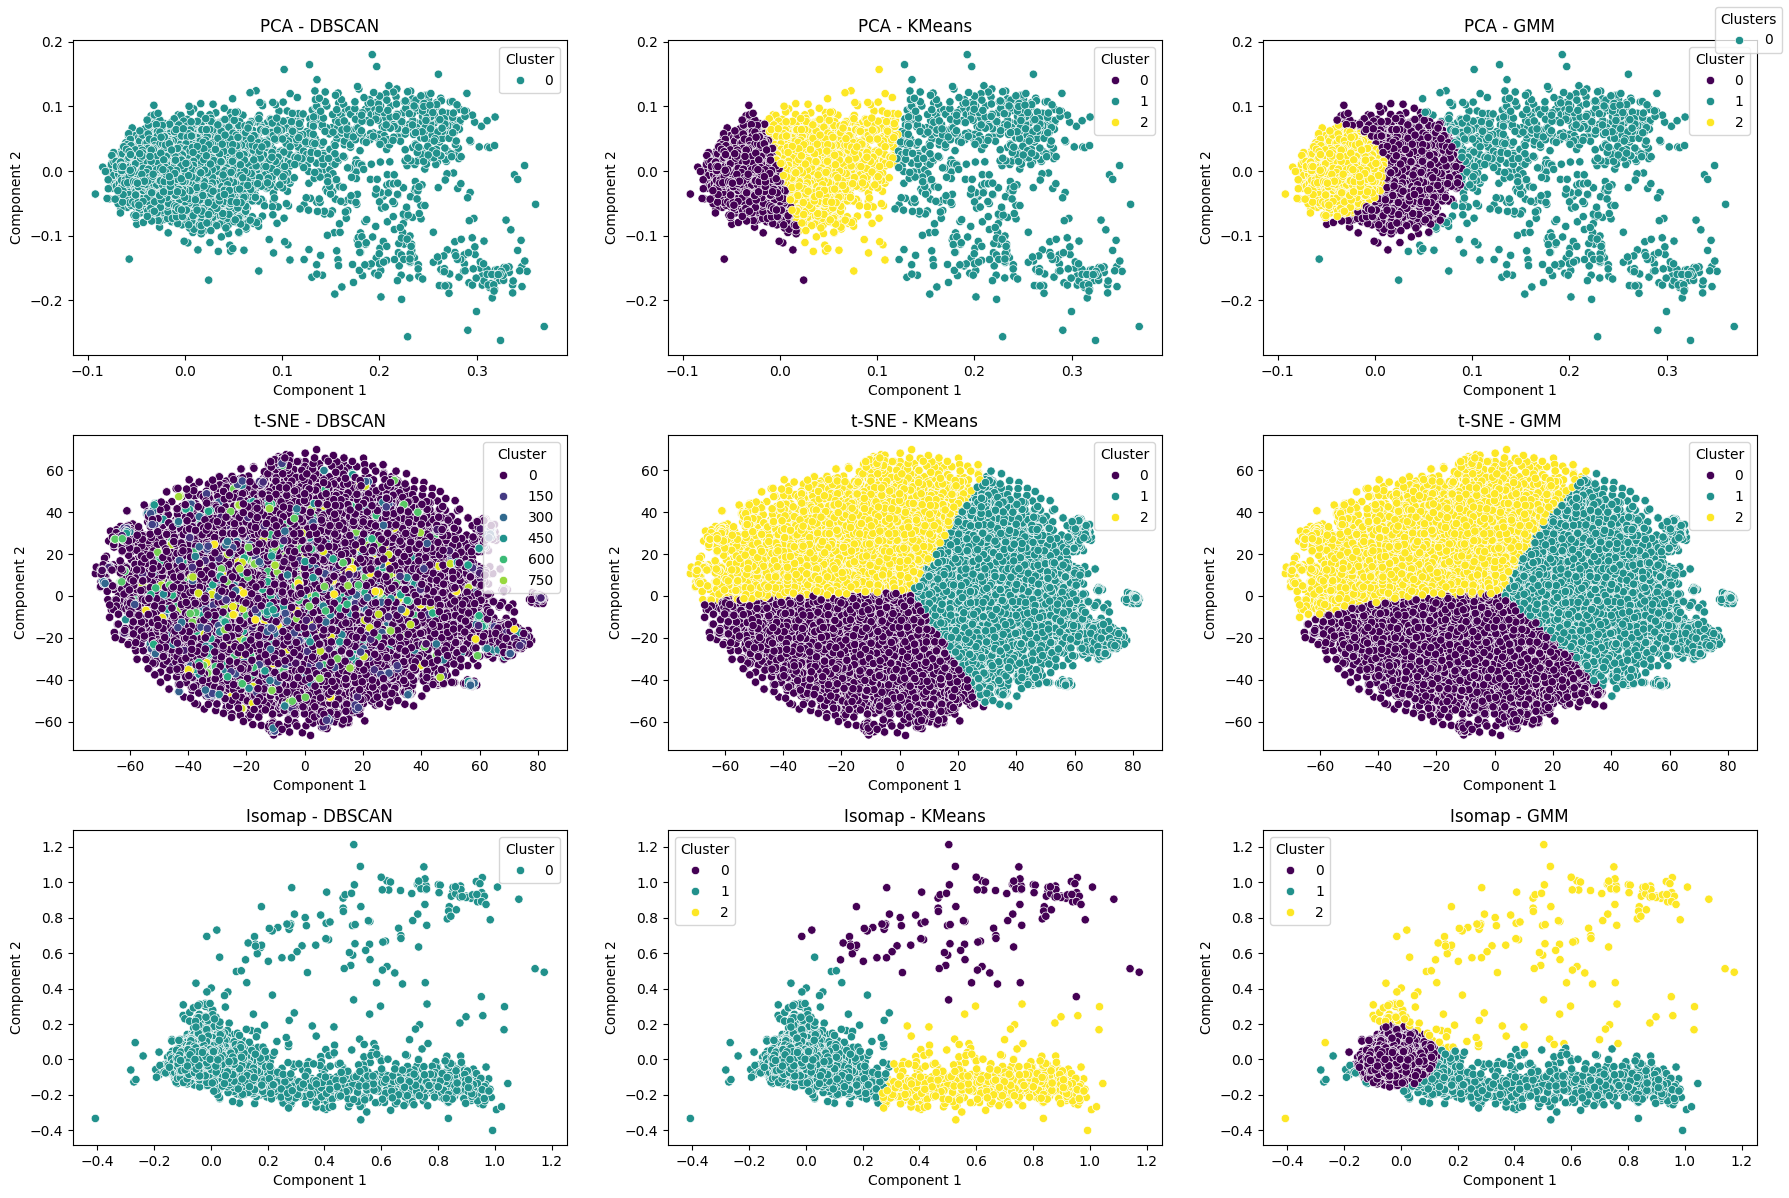

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture

n_clusters = 3
n_components = 2

clustering_methods = {
    "DBSCAN": DBSCAN(),
    "KMeans": KMeans(n_clusters=n_clusters),
    "GMM": GaussianMixture(n_components=n_clusters),
}

dimensionality_methods = {
    "PCA": PCA(n_components=n_components, random_state=seed),
    "t-SNE": TSNE(n_components=n_components, random_state=seed),
    "Isomap": Isomap(n_components=n_components),
}

fig, axes = plt.subplots(len(dimensionality_methods), len(clustering_methods), figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, (dim_name, dim_method) in enumerate(dimensionality_methods.items()):
    reduced_embeddings = dim_method.fit_transform(all_embeddings)
    
    for j, (cluster_name, cluster_method) in enumerate(clustering_methods.items()):
        cluster_labels = cluster_method.fit_predict(reduced_embeddings)
        
        df = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])
        df['Cluster'] = cluster_labels

        sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='Cluster', palette='viridis', ax=axes[i, j], legend='auto')
        axes[i, j].set_title(f'{dim_name} - {cluster_name}')
        axes[i, j].set_xlabel('Component 1')
        axes[i, j].set_ylabel('Component 2')

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title='Clusters', loc='upper right')

plt.tight_layout()
plt.show()

In [115]:
import bisect
from collections import deque
from dataclasses import dataclass, field
from heapq import heappop, heappush
from typing import Dict, List, Optional, Tuple

import numpy as np

@dataclass
class Node:
    data: np.ndarray
    level: int
    meta: Dict[str, str] = field(default_factory=dict)
    neighbors: Dict[int, List[Tuple[float, 'Node']]] = field(default_factory=dict, compare=False)

    def __post_init__(self):
        object.__setattr__(self, 'data', np.array(self.data))

    def add_neighbor(self, neighbor: 'Node', level: int, max_neighbors: int = 300):
        if level not in self.neighbors:
            self.neighbors[level] = []

        dist = np.linalg.norm(self.data - neighbor.data)
        bisect.insort(self.neighbors[level], (dist, neighbor))

        if len(self.neighbors[level]) > max_neighbors:
            self.neighbors[level] = self.neighbors[level][:max_neighbors]

    def get_neighbors(self, level: int) -> List[Tuple[float, 'Node']]:
        return self.neighbors.get(level, [])
    
    def __hash__(self):
        return hash((self.data.tobytes(), self.level))

    def __eq__(self, other: 'Node'):
        return np.array_equal(self.data, other.data) and self.level == other.level
    
    def __lt__(self, other: 'Node'):
        return np.linalg.norm(self.data) < np.linalg.norm(other.data)

class SIM:
    def __init__(self, max_level: int, max_neighbors: int = 16, ef_construction: int = 200, ef_search: int = 10):
        self.max_level = max_level
        self.max_neighbors = max_neighbors
        self.ef_construction = ef_construction
        self.ef_search = ef_search
        self.entry_point = None
        self.nodes = []
        self.assign_probas = self._set_probas(max_neighbors, 1 / np.log(max_neighbors))

    def _set_probas(self, max_neighbors: int, m_l: float):
        nn = 0 
        level = 0
        assign_probas = []

        while True:
            proba = np.exp(-level / m_l) * (1 - np.exp(-1 / m_l))
            
            if proba < 1e-9: 
                break
            
            assign_probas.append(proba)
            nn += max_neighbors * 2 if level == 0 else max_neighbors
            level += 1

        return assign_probas

    def _random_level(self) -> int:
        level = 0
        
        while level < self.max_level and np.random.rand() < self.assign_probas[level]:
            level += 1
        
        return level

    def _distance(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        return np.linalg.norm(vec1 - vec2)

    def insert(self, data: np.ndarray, symbol: str) -> None:
        level = self._random_level()
        new_node = Node(data, level, meta={"symbol": symbol})
        self.nodes.append(new_node)

        if self.entry_point is None:
            self.entry_point = new_node
            return

        current_node = self.entry_point

        for l in range(self.max_level, -1, -1):
            if l <= level:
                neighbors = self._beam_search_layer(current_node, new_node.data, l, self.ef_construction)
                new_node.neighbors[l] = self._select_best_neighbors(neighbors)

                for _, neighbor in new_node.neighbors[l]:
                    neighbor.add_neighbor(new_node, l, self.max_neighbors)

            current_node = self._greedy_search(new_node.data, current_node, l)

    def _beam_search_layer(self, entry_node: Node, query: np.ndarray, level: int, ef: int) -> List[Tuple[float, Node]]:
        candidates = [(self._distance(entry_node.data, query), entry_node)]
        visited = {entry_node}
        beam = []

        while candidates:
            dist, node = heappop(candidates)

            if len(beam) < ef:
                beam.append((dist, node))
            else:
                if dist < beam[-1][0]:
                    beam[-1] = (dist, node)

            for _, neighbor in node.get_neighbors(level):
                if neighbor not in visited:
                    visited.add(neighbor)

                    heappush(candidates, (self._distance(neighbor.data, query), neighbor))

        return beam

    def _greedy_search(self, query: np.ndarray, entry_node: Node, level: int) -> Node:
        current_node = entry_node
        current_dist = self._distance(query, current_node.data)

        while True:
            found_closer = False
            for _, neighbor in current_node.get_neighbors(level):
                dist = self._distance(query, neighbor.data)
                if dist < current_dist:
                    current_node = neighbor
                    current_dist = dist
                    found_closer = True

            if not found_closer:
                break

        return current_node

    def _select_best_neighbors(self, neighbors: List[Tuple[float, Node]]) -> List[Tuple[float, Node]]:
        return sorted(neighbors, key=lambda x: x[0])[:self.max_neighbors] if len(neighbors) > self.max_neighbors else neighbors

    def search(self, query: np.ndarray, top_k: int = 10) -> Optional[List[Tuple[float, Node]]]:
        if self.entry_point is None:
            return None

        current_node = self.entry_point
        ef = max(self.ef_search, top_k)
        candidates = []
        visited = set()
  
        for l in range(self.max_level, -1, -1):
            candidates += self._beam_search_layer(current_node, query, l, ef)
            visited.update(node for _, node in candidates)

            current_node = self._greedy_search(query, current_node, l)

        re_ranked_results = sorted(set(candidates), key=lambda x: x[0])

        return re_ranked_results[:top_k]
    
    def find_simular_symbols(self, symbol: str, top_k: int = 10):
        if self.entry_point is None:
            return []
        
        target_node = self._locate_node_by_symbol(symbol)

        return self.search(target_node.data, top_k) if target_node else []
    
    def _locate_node_by_symbol(self, symbol: str) -> Optional[Node]:
        visited = set()
        stack = [self.entry_point]

        while stack:
            current_node = stack.pop()
            visited.add(current_node)

            if current_node.meta.get("symbol") == symbol:
                return current_node

            for level in range(self.max_level + 1):
                for _, neighbor in current_node.get_neighbors(level):
                    if neighbor not in visited:
                        stack.append(neighbor)

        return None
    

In [42]:
from sklearn.decomposition import PCA

n_reduced = 10
embedding_lengths = res_df['flat_embeddings'].apply(len)
unique_lengths = embedding_lengths.value_counts()

print("Unique embedding lengths and counts:")
print(unique_lengths)

max_length = unique_lengths.idxmax() if not unique_lengths.empty else 0
print("Maximum embedding length:", max_length)

def adjust_embedding_length(emb, target_length):
    emb = np.array(emb)

    if len(emb) < target_length:
        pad_width = target_length - len(emb)
        return np.pad(emb, (0, pad_width), 'constant')
    return emb[:target_length]
    
res_df['adj_embeddings'] = res_df['flat_embeddings'].apply(lambda emb: adjust_embedding_length(emb, max_length))
adjusted_embeddings = np.array(res_df['adj_embeddings'].tolist())

pca = PCA(n_components=n_reduced)
reduced_embeddings = pca.fit_transform(adjusted_embeddings)

res_df['reduced_embeddings'] = list(reduced_embeddings)

reduced_lengths = res_df['reduced_embeddings'].apply(len)
reduced_uniq_lengths = reduced_lengths.value_counts()

print("Reduced embedding lengths and counts:")
print(reduced_uniq_lengths)

Unique embedding lengths and counts:
flat_embeddings
1632    410
2624      1
Name: count, dtype: int64
Maximum embedding length: 1632
Reduced embedding lengths and counts:
reduced_embeddings
10    411
Name: count, dtype: int64


In [43]:
res_df[['symbol', 'reduced_embeddings']].values

array([['10000000AIDOGEUSDT',
        array([ 0.01547666, -0.01722563,  0.04969973, -0.07968023,  0.10070723,
               -0.09389678,  0.02481912, -0.03506392,  0.12172557, -0.01319712],
              dtype=float32)                                                    ],
       ['1000000BABYDOGEUSDT',
        array([-0.06924997, -0.02171121, -0.00093387, -0.06080772,  0.0152021 ,
                0.0258026 , -0.18374854,  0.17671172, -0.02110103, -0.03587031],
              dtype=float32)                                                    ],
       ['1000000MOGUSDT',
        array([ 0.08311179,  0.01347193, -0.04553906,  0.04334055, -0.10050446,
               -0.06331265, -0.2088073 ,  0.15395615,  0.11308145, -0.04516197],
              dtype=float32)                                                    ],
       ['1000000PEIPEIUSDT',
        array([ 0.00480361, -0.01398117,  0.10903479,  0.09818728, -0.12995447,
                0.00315276,  0.15543708,  0.1357361 ,  0.12890853,  0.01

In [118]:
data = res_df[['symbol', 'reduced_embeddings']].values

sim = SIM(max_level=5, max_neighbors=60, ef_construction=200, ef_search=30)

for symbol, emb in data:
    sim.insert(emb, symbol)

In [119]:
symbol = 'BTCUSDT'
val = res_df[res_df['symbol'] == symbol]['reduced_embeddings'].values
query = val[0]

print(f"Symbol: {symbol}")
print(f"Query: {query}")

neighbors = sim.search(query, 5)
n_neighbors = len(neighbors)

print(f"Found {n_neighbors} nearest neighbors for the query.")

for i, neighbors in enumerate(neighbors):
    dist, node = neighbors
    print(f"{i} neighbor Symbol: {node.meta['symbol']}")


symbols = sim.find_simular_symbols(symbol)
n_symbols = len(symbols)

print(f"Found {n_symbols} simular symbols")

for _, symbol in enumerate(symbols):
    dist, node = symbol
    print(f"Symbol: {node.meta['symbol']}")

Symbol: BTCUSDT
Query: [-0.09020187 -0.13381095  0.08651141 -0.13797197  0.0141624  -0.0060244
  0.02903362  0.12265816 -0.01085904 -0.04653133]
Found 5 nearest neighbors for the query.
0 neighbor Symbol: BTCUSDT
1 neighbor Symbol: CLOUDUSDT
2 neighbor Symbol: SUNDOGUSDT
3 neighbor Symbol: RENDERUSDT
4 neighbor Symbol: KNCUSDT
Found 10 simular symbols
Symbol: BTCUSDT
Symbol: CLOUDUSDT
Symbol: SUNDOGUSDT
Symbol: RENDERUSDT
Symbol: KNCUSDT
Symbol: AKROUSDT
Symbol: JASMYUSDT
Symbol: RADUSDT
Symbol: CTSIUSDT
Symbol: STMXUSDT
